In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
f = pd.read_hdf('../h5files/events_anomalydetection.h5', stop=10000) #read only first 'stop' events

In [3]:
events_combined = f.T
np.shape(events_combined)


(2101, 10000)

background 0
signal 0


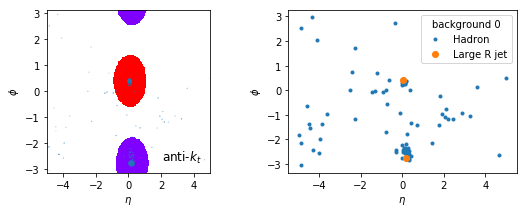

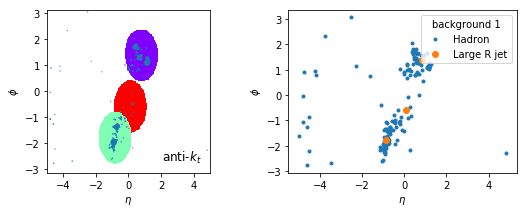

In [4]:
fillGhost = True
plotArea = True

#Now, let's cluster some jets more efficiently!
all_largeRjets = {}
all_smallRjets = {}
all_hadrons = {}

all_largeRjets_ghost = {}
all_smallRjets_ghost = {}
all_hadrons_ghost = {}


# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -5., 5.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 200
kt, r, R=-1, 0.4, 1.0
pcut = 20

for mytype in ['background','signal']:
    all_largeRjets[mytype]=[]
    all_smallRjets[mytype]=[]
    all_hadrons[mytype]=[]
    all_largeRjets_ghost[mytype]=[]
    all_smallRjets_ghost[mytype]=[]
    all_hadrons_ghost[mytype]=[]
    
    for ievt in range(2): #len(events_combined)):
        if ievt%10000==0:
            print(mytype,ievt)
        issignal = events_combined[ievt][2100]
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
            continue
        pseudojets_input = np.zeros(len([x for x in events_combined[ievt][::3] if x > 0]), dtype=DTYPE_PTEPM)
        events_filled = events_combined[ievt][:np.shape(pseudojets_input)[0]*3].values.reshape(np.shape(pseudojets_input)[0], 3)

        pseudojets_input['pT'] = events_filled[:, 0]
        pseudojets_input['eta'] = events_filled[:, 1]
        pseudojets_input['phi'] = events_filled[:, 2]
        largeR = cluster(pseudojets_input, R=R, p=kt)
        largeRjets = largeR.inclusive_jets(ptmin=pcut)
        smallR = cluster(pseudojets_input, R=r, p=kt)
        smallRjets = smallR.inclusive_jets(ptmin=pcut)

        all_largeRjets[mytype] += [largeRjets]
        all_smallRjets[mytype] += [smallRjets]
        all_hadrons[mytype] += [pseudojets_input]
    
    
        if fillGhost:
            # create regular grid of ghosts
            eta_edges = np.linspace(eta_min, eta_max, bins + 1)
            phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
            eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
            phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
            X, Y = np.meshgrid(eta, phi)
            ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
            ghosts['pT'], ghosts['eta'], ghosts['phi'] = 1e-8, X.ravel(), Y.ravel()
            
            pseudojets_input_ghost = np.concatenate([pseudojets_input, ghosts])
            
            largeR_ghost = cluster(pseudojets_input_ghost, R=R, p=kt)
            largeRjets_ghost = largeR_ghost.inclusive_jets(ptmin=pcut)
            all_largeRjets_ghost[mytype] += [largeRjets_ghost]
            all_hadrons_ghost[mytype] += [pseudojets_input_ghost]


            smallR_ghost = cluster(pseudojets_input_ghost, R=0.4, p=-1)
            smallRjets_ghost = smallR_ghost.inclusive_jets(ptmin=20)

            all_smallRjets_ghost[mytype] += [smallRjets_ghost]

        if plotArea:
            fig = plt.figure(figsize=(9, 3))

            # pick a different color for each jet
            colors = cm.rainbow(np.linspace(0, 1, len(largeRjets_ghost)))
            cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
            ax = fig.add_subplot(1, 2, 1)
            area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                            dtype=np.float64)
            for ijet, jet in enumerate(largeRjets_ghost):
                constit = jet.constituents_array()
                jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                               bins=(eta_edges, phi_edges))
                area += (jetarea > 0) * (ijet + 1)

            # plot all areas
            ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
                      extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
                      interpolation='none', origin='lower')

            # overlay original event
            particles = pseudojets_input
            ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())
            ax.set_xlim(extent[:2])
            ax.set_ylim(extent[2:])
            ax.set_ylabel(r'$\phi$')
            ax.set_xlabel(r'$\eta$')

            ax.text(0.95, 0.05, r'anti-$k_t$',
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes,
                fontsize=12)

            ax = fig.add_subplot(1, 2, 2)
            plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], marker='.', label='Hadron')
            jets_eta = [all_largeRjets[mytype][ievt][ijet].eta for ijet in range(len(all_largeRjets[mytype][ievt]))]
            jets_phi = [all_largeRjets[mytype][ievt][ijet].phi for ijet in range(len(all_largeRjets[mytype][ievt]))]

            plt.scatter(x=jets_eta, y=jets_phi, marker='o', label='Large R jet')
            plt.xlabel(r'$\eta$')
            plt.ylabel(r'$\phi$')
            plt.legend(loc='upper right', title=mytype+' '+str(ievt))



In [5]:
def getJet(alljets, index):
    jet = {}
    for mytype in ['background','signal']:
        jet[mytype]={'pt':[], 'eta':[], 'phi':[]}
        for ievt in range(len(all_largeRjets[mytype])):
            jet[mytype]['pt'] += [alljets[mytype][ievt][index].pt]
            jet[mytype]['eta'] += [alljets[mytype][ievt][index].eta]
            jet[mytype]['phi'] += [alljets[mytype][ievt][index].phi]
    return jet

lead_largeRjets, sublead_largeRjets = getJet(all_largeRjets, 0), getJet(all_largeRjets, 1)
lead_smallRjets, sublead_smallRjets = getJet(all_smallRjets, 0), getJet(all_smallRjets, 1)
print(len(lead_largeRjets), lead_largeRjets)

2 {'background': {'pt': [1286.7276854490954, 1354.3940698848066], 'eta': [0.18550794794312087, 0.8265051414289109], 'phi': [-2.763675891801303, 1.365523633651283]}, 'signal': {'pt': [], 'eta': [], 'phi': []}}


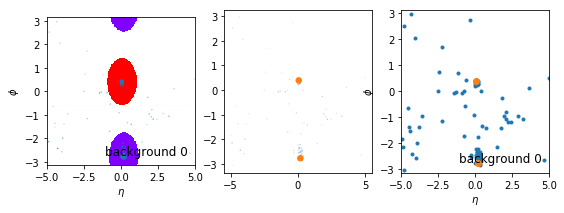

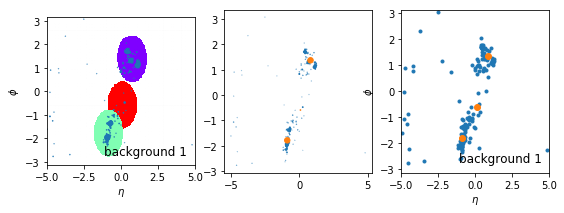

In [13]:
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

plotGhost = True
plotPosition = True

def plot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = 'background', ievt = 0):
    fig = plt.figure(figsize=(9, 3))

    if plotGhost:
        event = all_largeRjets_ghost[mytype][ievt]
        # pick a different color for each jet
        colors = cm.rainbow(np.linspace(0, 1, len(event)))
        cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
        ax = fig.add_subplot(1, 3, 1)
        area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1), dtype=np.float64)
        for ijet, jet in enumerate(event):
            constit = jet.constituents_array()
            jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'], bins=(eta_edges, phi_edges))
            area += (jetarea > 0) * (ijet + 1)

        # plot all areas
        ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
                  extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
                  interpolation='none', origin='lower')

        # overlay original event
        particles = all_hadrons_ghost[mytype][ievt]
#         particles = pseudojets_input
        ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())

        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])
        plt.xlabel(r'$\eta$')
        plt.ylabel(r'$\phi$')

        ax.text(0.95, 0.05, mytype+' '+str(ievt),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            fontsize=12)

    if plotPosition:
        jets_eta = [all_largeRjets[mytype][ievt][ijet].eta for ijet in range(len(all_largeRjets[mytype][ievt]))]
        jets_phi = [all_largeRjets[mytype][ievt][ijet].phi for ijet in range(len(all_largeRjets[mytype][ievt]))]
        jets_pt = np.array([all_largeRjets[mytype][ievt][ijet].pt for ijet in range(len(all_largeRjets[mytype][ievt]))])
        ax = fig.add_subplot(1, 3, 2)
        plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], s=30 * all_hadrons[mytype][ievt]['pT'] / all_hadrons[mytype][ievt]['pT'].max(), marker='.')
        plt.scatter(x=jets_eta, y=jets_phi, s=30 * jets_pt/max(jets_pt), marker='o')
        ax = fig.add_subplot(1, 3, 3)
        plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], marker='.')
        plt.scatter(x=jets_eta, y=jets_phi, marker='o')
        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])
        plt.xlabel(r'$\eta$')
        plt.ylabel(r'$\phi$')
        ax.text(0.95, 0.05, mytype+' '+str(ievt),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            fontsize=12)        
    
for mytype in ['background','signal']:
    for ievt in range(len(all_largeRjets_ghost[mytype])):
        plot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = mytype, ievt = ievt)


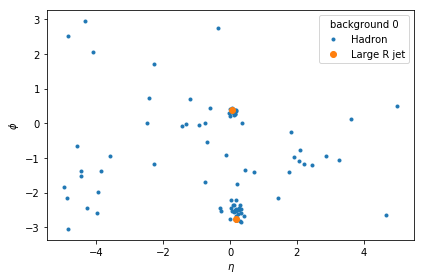

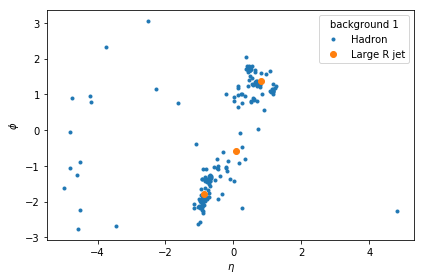

In [8]:
#Let's make some very simple plots.
def plothadron():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    n,b,p = plt.hist(pseudojets_input['eta'], bins=50, facecolor='r', alpha=0.2,label='background')
    plt.xlabel(r'$\eta$')
    plt.ylabel('Number of hadrons')
    plt.legend(loc='upper right')

def plothadron2d(all_hadrons, all_largeRjets, mytype, ievt):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(x=all_hadrons[mytype][ievt]['eta'], y=all_hadrons[mytype][ievt]['phi'], marker='.', label='Hadron')
    jets_eta = [all_largeRjets[mytype][ievt][ijet].eta for ijet in range(len(all_largeRjets[mytype][ievt]))]
    jets_phi = [all_largeRjets[mytype][ievt][ijet].phi for ijet in range(len(all_largeRjets[mytype][ievt]))]
    
    plt.scatter(x=jets_eta, y=jets_phi, marker='o', label='Large R jet')
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')
    plt.legend(loc='upper right', title=mytype+' '+str(ievt))
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
    fig.tight_layout()

for mytype in ['background','signal']:
    for ievt in range(len(all_largeRjets_ghost[mytype])):
        plothadron2d(all_hadrons, all_largeRjets, mytype, ievt)
#         plothadron()


NameError: name 'leadpT_largeRjets' is not defined

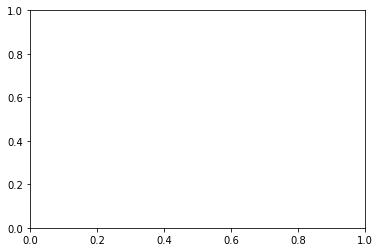

In [33]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT_largeRjets['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(leadpT_largeRjets['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("leadjetpt.pdf")

In [34]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(all_largeRjets[mytype])):
        E = all_largeRjets[mytype][k][0].e+all_largeRjets[mytype][k][1].e
        px = all_largeRjets[mytype][k][0].px+all_largeRjets[mytype][k][1].px
        py = all_largeRjets[mytype][k][0].py+all_largeRjets[mytype][k][1].py
        pz = all_largeRjets[mytype][k][0].pz+all_largeRjets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]


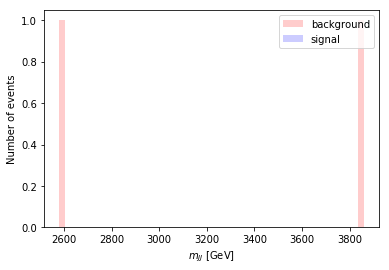

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("mjj.pdf")